### О важности удаления выбросов

In [53]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime

In [54]:
item = 'countymurders' # Выбрать из поля Item для вашего датасета
package = 'wooldridge' # Выбрать из поля Package для вашего датасета

data = sm.datasets.get_rdataset(item, package , cache=True).data
data.head()

,arrests,countyid,density,popul,perc1019,perc2029,percblack,percmale,rpcincmaint,rpcpersinc,rpcunemins,year,murders,murdrate,arrestrate,statefips,countyfips,execs,lpopul,execrate
0,2.0,1001,54.05,32216,20.63,15.28,22.33,40.25,167.67,8780.80,29.16,1980,2,0.620810,0.620810,1,1,0,10.38022,0.0
1,3.0,1001,53.66,31984,20.19,15.55,22.07,40.36,167.99,8232.80,43.92,1981,1,0.312656,0.937969,1,1,0,10.37299,0.0
2,2.0,1001,53.75,32036,19.66,15.73,21.80,40.42,166.63,8327.61,71.41,1982,3,0.936446,0.624298,1,1,0,10.37462,0.0
3,7.0,1001,53.78,32056,19.10,15.88,21.53,40.47,176.53,8545.55,72.22,1983,7,2.183679,2.183679,1,1,0,10.37524,0.0
4,3.0,1001,53.91,32128,18.54,15.92,21.26,40.51,166.25,8965.16,40.36,1984,2,0.622510,0.933765,1,1,0,10.37748,0.0


In [55]:
data.shape

(37349, 20)

In [56]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37349 entries, 0 to 37348
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   arrests      36845 non-null  float64
 1   countyid     37349 non-null  int64  
 2   density      37349 non-null  float64
 3   popul        37349 non-null  int64  
 4   perc1019     37349 non-null  float64
 5   perc2029     37349 non-null  float64
 6   percblack    37349 non-null  float64
 7   percmale     37349 non-null  float64
 8   rpcincmaint  37346 non-null  float64
 9   rpcpersinc   37346 non-null  float64
 10  rpcunemins   37346 non-null  float64
 11  year         37349 non-null  int64  
 12  murders      37349 non-null  int64  
 13  murdrate     37349 non-null  float64
 14  arrestrate   36845 non-null  float64
 15  statefips    37349 non-null  int64  
 16  countyfips   37349 non-null  int64  
 17  execs        37349 non-null  int64  
 18  lpopul       37349 non-null  float64
 19  exec

In [6]:
data['year'].unique()

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996])

In [57]:
data = data[data['year']==1996]

In [58]:
data.shape

(2197, 20)

In [59]:
cat_vars = ['countyid']
num_vars = ['arrestrate', 'density', 'perc1019', 'perc2029', 'percblack', 'percmale', 'rpcincmaint', 'rpcpersinc', 'rpcunemins', 'execrate']
target_var = ['murdrate']

### Заполним пропуски

In [60]:
na_cols = data.columns[data.isna().any()]
for col in na_cols:
    median = data.loc[:, col].dropna().median()
    data.loc[:, col] = data.loc[:, col].fillna(value = median)

### Посмотрим на распределение целевой переменной

array([[<Axes: title={'center': 'murdrate'}>]], dtype=object)

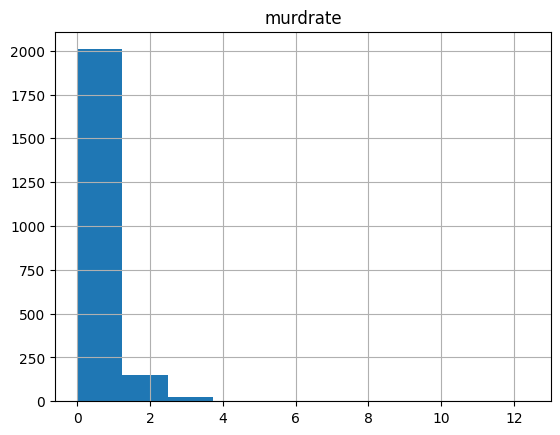

In [12]:
data[target_var].hist()

По распределению видно, что есть выбросы в правом хвосте

### Обучим модель без учета выбросов

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data[cat_vars + num_vars], data[target_var], test_size = 0.4, random_state = 42)

In [14]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train, y_train)

LinearRegression()

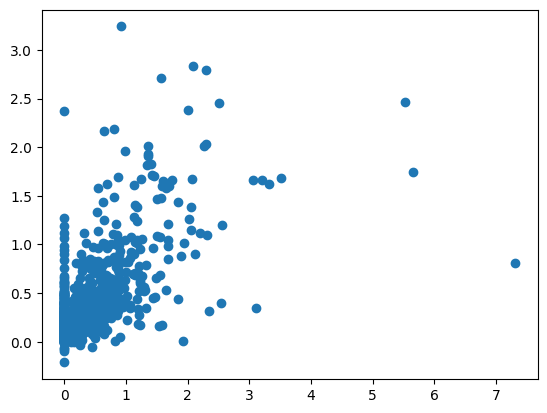

In [15]:
y_pred = ols.predict(X_test)
plt.scatter(y_test, y_pred)
plt.show()

Видно несколько наблюдений по диаграмме:

1) В данных есть выбросы (точки, которые находятся далеко справа)

2) Есть графства с нулевым процентом убийств

Исходя из этого, нужно сделать два шага для повышения качества модели:

1) Убрать из данных выбросы

2) Обучить выборку только на тех наблюдениях, для которых значение целевой переменной не нулевое

Чтобы совсем не исключить из рассмотрения те графства, у которых нет убийств, нужно построить ансамбль моделей:

1) Модель классификации (1 - убийства будут и 0 - убийств не будет)

2) На тех графствах, для которых 1 модель предсказала наличие убийств делать прогноз процента убийств. Для остальных этот процент будет нулевой

### Убираем выбросы

In [61]:
data['murdrate'].describe()

count    2197.000000
mean        0.421732
std         0.778952
min         0.000000
25%         0.000000
50%         0.115805
75%         0.625587
max        12.391570
Name: murdrate, dtype: float64

In [62]:
q1 = data['murdrate'].quantile(0.25)
q3 = data['murdrate'].quantile(0.75)
iqr = q3 - q1
data = data[(data['murdrate']>=q1 - 1.5*iqr)&(data['murdrate']<=q3 + 1.5*iqr)]

In [63]:
data.shape

(2074, 20)

### Обучаем задачу классификации

In [65]:
y_clf = np.where(data[target_var] == 0, 0, 1)
X_clf = data[num_vars + cat_vars]

### Делим выборку на обучающую, тестовую и прогнозную


In [66]:
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, test_size = 0.4, random_state = 42)

#### Обучим модель логистической регрессии

In [67]:
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(random_state=0).fit(X_train_clf, y_train_clf)

C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
y_pred_clf = logit.predict(X_test_clf)

In [69]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(confusion_matrix(y_test_clf, y_pred_clf), index = ['True 0', 'True 1'], columns = ['Pred 0', 'Pred 1'])

,Pred 0,Pred 1
True 0,371,56
True 1,166,237


In [70]:
from sklearn.metrics import precision_score, recall_score
print('Precision', precision_score(y_test_clf, y_pred_clf))
print('Recall', recall_score(y_test_clf, y_pred_clf))

Precision 0.8088737201365188
Recall 0.5880893300248139


### Обучаем задачу регрессии

#### Оставляем в выборке только те графства, где есть ненулевые убийства

In [45]:
data_nonnull = data[data['murdrate']>0]

#### Linear Regression (OLS)

In [71]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(data_nonnull[cat_vars + num_vars], data_nonnull[target_var], test_size = 0.4, random_state = 42)

In [72]:
from sklearn import linear_model
ols = linear_model.LinearRegression()
ols.fit(X_train_reg, y_train_reg)

LinearRegression()

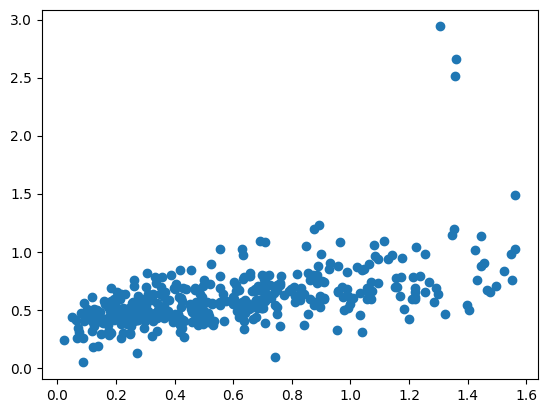

In [74]:
y_pred_reg = ols.predict(X_test_reg)
plt.scatter(y_test_reg, y_pred_reg)
plt.show()

### Метрики качества модели регрессии

In [75]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
print('R2', r2_score(y_test_reg, y_pred_reg))
print('MAE', mean_absolute_error(y_test_reg, y_pred_reg))
print('RMSE', np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)))
print('MAPE', mean_absolute_percentage_error(y_test_reg, y_pred_reg))

R2 0.2717694983975997
MAE 0.24438206751725128
RMSE 0.3177713742853074
MAPE 0.7330269822492343


### Оценим качество ансамбля моделей

1) Возьмем тестовую выборку задачи классификации

2) Для этой выборки сделаем предсказание, будет или нет совершено убийство в графстве

3) Для тех графств, в которых будет совершено убийство, сделаем предсказание количества убийств с помощью модели регрессии

4) Оценим качество модели в совокупности

In [79]:
test_obs = X_test_clf.index

In [83]:
test_data = data.loc[test_obs, cat_vars + num_vars + target_var]
test_data.head()

,countyid,arrestrate,density,perc1019,perc2029,percblack,percmale,rpcincmaint,rpcpersinc,rpcunemins,execrate,murdrate
15724,30027,0.000000,2.926253,15.07443,8.608333,0.102386,49.34237,148.654,11246.660,58.696,0.0,0.000000
8176,18143,0.000000,118.970900,15.68956,13.477840,0.092707,48.82130,215.006,11230.710,33.176,0.0,0.441462
33166,51111,0.900576,25.718190,14.10303,9.347982,40.246760,48.58609,249.458,9240.792,30.624,0.0,0.900576
24122,42001,0.353270,163.315700,14.45697,13.191080,1.388349,48.99848,90.596,13250.620,68.904,0.0,0.117757
5201,16077,0.000000,5.857755,20.40321,11.926160,0.157882,50.24290,161.414,10785.390,67.628,0.0,1.214477


In [84]:
test_data['is_murder_pred'] = y_test_clf
test_data.head()

,countyid,arrestrate,density,perc1019,perc2029,percblack,percmale,rpcincmaint,rpcpersinc,rpcunemins,execrate,murdrate,is_murder_pred
15724,30027,0.000000,2.926253,15.07443,8.608333,0.102386,49.34237,148.654,11246.660,58.696,0.0,0.000000,0
8176,18143,0.000000,118.970900,15.68956,13.477840,0.092707,48.82130,215.006,11230.710,33.176,0.0,0.441462,1
33166,51111,0.900576,25.718190,14.10303,9.347982,40.246760,48.58609,249.458,9240.792,30.624,0.0,0.900576,1
24122,42001,0.353270,163.315700,14.45697,13.191080,1.388349,48.99848,90.596,13250.620,68.904,0.0,0.117757,1
5201,16077,0.000000,5.857755,20.40321,11.926160,0.157882,50.24290,161.414,10785.390,67.628,0.0,1.214477,1


In [85]:
X_test_clf_reg = test_data.loc[test_data['is_murder_pred']==1, cat_vars + num_vars]
y_pred_clf_reg = ols.predict(X_test_clf_reg)

In [88]:
test_data.loc[test_data['is_murder_pred']==1,'pred_murder'] = y_pred_clf_reg
test_data['pred_murder'] = test_data['pred_murder'].fillna(0)
test_data 

,countyid,arrestrate,density,perc1019,perc2029,percblack,percmale,rpcincmaint,rpcpersinc,rpcunemins,execrate,murdrate,is_murder_pred,pred_murder
15724,30027,0.000000,2.926253,15.07443,8.608333,0.102386,49.34237,148.654,11246.660,58.696,0.0,0.000000,0,0.000000
8176,18143,0.000000,118.970900,15.68956,13.477840,0.092707,48.82130,215.006,11230.710,33.176,0.0,0.441462,1,0.482089
33166,51111,0.900576,25.718190,14.10303,9.347982,40.246760,48.58609,249.458,9240.792,30.624,0.0,0.900576,1,0.980930
24122,42001,0.353270,163.315700,14.45697,13.191080,1.388349,48.99848,90.596,13250.620,68.904,0.0,0.117757,1,0.438331
5201,16077,0.000000,5.857755,20.40321,11.926160,0.157882,50.24290,161.414,10785.390,67.628,0.0,1.214477,1,0.492145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33319,51133,0.890789,58.376890,10.42223,8.311064,31.302330,47.22964,138.446,14342.240,74.646,0.0,0.000000,0,0.000000
3348,6109,0.383171,23.347150,12.29788,10.799680,3.513679,53.32401,281.358,11367.250,68.266,0.0,0.191586,1,0.590355
27777,48021,0.640765,52.699350,14.91702,10.636710,12.441530,50.68455,167.156,10988.910,29.348,0.0,1.495119,1,0.708217
36107,55035,0.224979,139.414600,16.66311,16.648480,0.343094,48.25922,135.256,13361.000,54.868,0.0,0.449959,1,0.380813


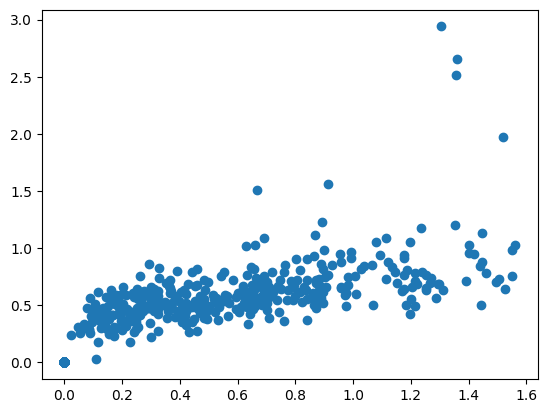

In [89]:
plt.scatter(test_data['murdrate'], test_data['pred_murder'])
plt.show()

In [90]:
print('R2', r2_score(test_data['murdrate'], test_data['pred_murder']))
print('MAE', mean_absolute_error(test_data['murdrate'], test_data['pred_murder']))
print('RMSE', np.sqrt(mean_squared_error(test_data['murdrate'], test_data['pred_murder'])))
print('MAPE', mean_absolute_percentage_error(test_data['murdrate'], test_data['pred_murder']))

R2 0.6909386496498918
MAE 0.11620715442395994
RMSE 0.21844103423302336
MAPE 0.34700878813439046


### Кластеризация

Кластеризация - это поиск скрытых закономерностей или схожестей между объектами наблюдения в данных на основе собранных переменных

In [91]:
item = 'countymurders' # Выбрать из поля Item для вашего датасета
package = 'wooldridge' # Выбрать из поля Package для вашего датасета

data = sm.datasets.get_rdataset(item, package , cache=True).data
data = data[data['year']==1996]
data.head()

,arrests,countyid,density,popul,perc1019,perc2029,percblack,percmale,rpcincmaint,rpcpersinc,rpcunemins,year,murders,murdrate,arrestrate,statefips,countyfips,execs,lpopul,execrate
16,8.0,1001,67.21535,40061,15.89077,13.17491,20.975510,48.70073,192.038,11852.760,26.796,1996,7,1.747335,1.996955,1,1,0,10.598160,0.0
33,6.0,1003,77.05643,123023,13.93886,11.63929,13.496660,48.83233,139.084,13583.020,28.710,1996,6,0.487714,0.487714,1,3,0,11.720130,0.0
50,1.0,1005,29.91548,26475,15.06327,13.69972,46.190750,49.15203,405.768,10760.510,63.162,1996,1,0.377715,0.377715,1,5,0,10.183960,0.0
67,0.0,1009,67.20457,43392,14.17542,12.99318,1.415007,48.97446,184.382,11094.820,21.692,1996,2,0.460915,0.000000,1,9,0,10.678030,0.0
84,1.0,1011,17.89899,11188,14.98927,14.13121,72.756520,49.91956,485.518,8349.506,63.162,1996,0,0.000000,0.893815,1,11,0,9.322598,0.0


In [92]:
len(data['countyid'].unique())

2197

Основная идея кластеризации разделить все наблюдения на несколько групп так, чтобы внутри группы наблюдения были максимально схожи, а группы при этом максимально отличались друг от друга

#### Проведем кластеризацию по двум признакам

In [130]:
X = data[['murdrate', 'percblack']]

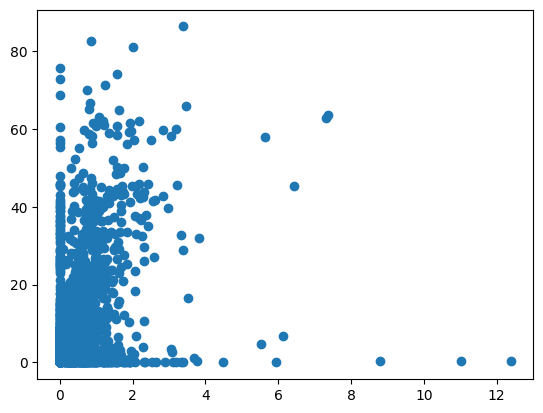

In [131]:
plt.scatter(X['murdrate'], X['percblack'])

#### Нормализуем переменные

In [132]:
from sklearn.preprocessing import MinMaxScaler
minmaxscaler =  MinMaxScaler().fit(X)  # fit does nothing
X_norm = minmaxscaler.transform(X)

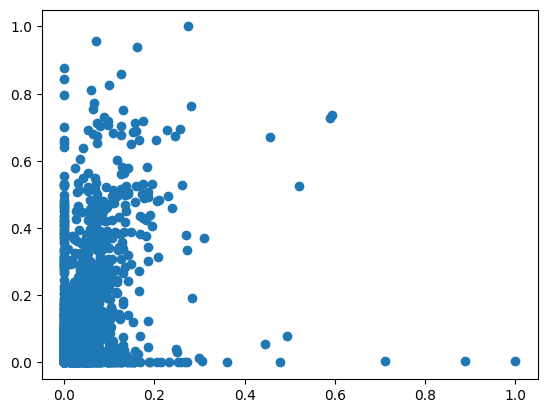

In [133]:
plt.scatter(X_norm[:,0], X_norm[:,1])

#### Для кластеризации применим метод K-means

In [134]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(X_norm)

In [135]:
X['cluster_2'] = kmeans.labels_

C:\Users\D\AppData\Local\Temp\ipykernel_14860\3425817590.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster_2'] = kmeans.labels_


In [136]:
X

,murdrate,percblack,cluster_2
16,1.747335,20.975510,0
33,0.487714,13.496660,1
50,0.377715,46.190750,0
67,0.460915,1.415007,1
84,0.000000,72.756520,0
...,...,...,...
37280,0.496007,0.783691,1
37297,0.000000,0.287039,1
37314,0.000000,0.192545,1
37331,0.000000,0.243704,1


<Axes: xlabel='murdrate', ylabel='percblack'>

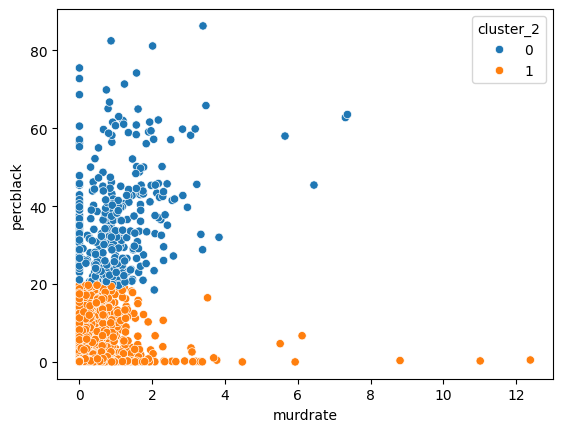

In [137]:
sns.scatterplot(x = 'murdrate', y = 'percblack', hue = 'cluster_2', data = X)

#### Попробуем разделить на 3 кластера

In [138]:
kmeans = KMeans(n_clusters = 3, random_state=0, n_init="auto").fit(X_norm)

In [139]:
X['cluster_3'] = kmeans.labels_

C:\Users\D\AppData\Local\Temp\ipykernel_14860\2310907286.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster_3'] = kmeans.labels_


<Axes: xlabel='murdrate', ylabel='percblack'>

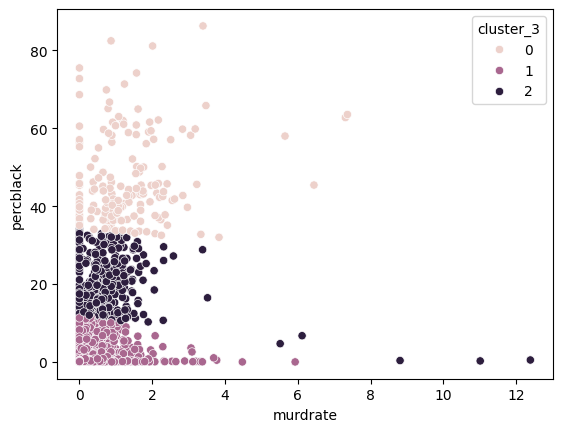

In [140]:
sns.scatterplot(x = 'murdrate', y = 'percblack', hue = 'cluster_3', data = X)

Text(0.5, 1.0, 'Elbow curve')

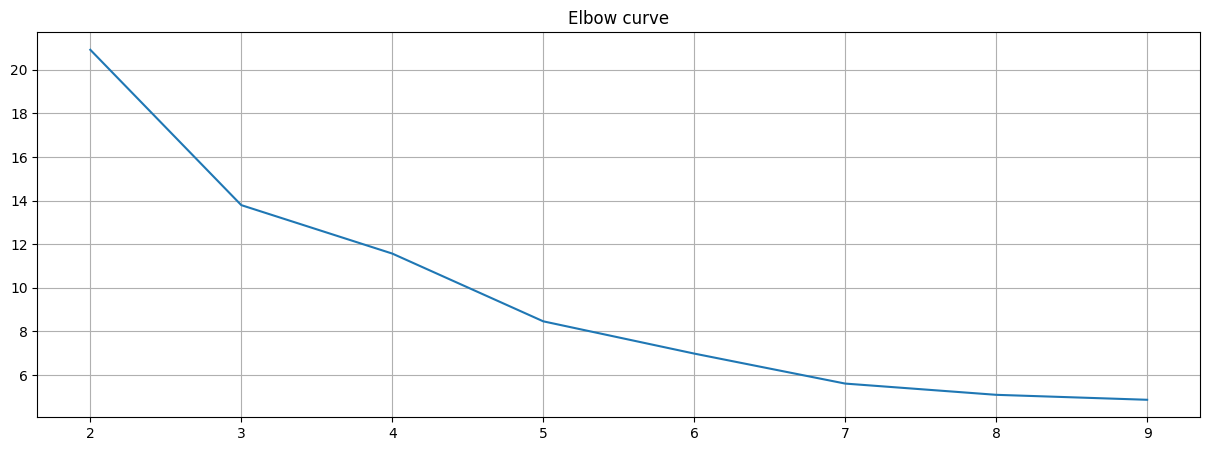

In [141]:
distorsions = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_norm)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 10), distorsions)
plt.grid(True)
plt.title('Elbow curve')

На основе метода локтя можем сказать, что наилучшим количеством кластеров является 5

C:\Users\D\AppData\Local\Temp\ipykernel_14860\202845748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['cluster_5'] = kmeans.labels_


<Axes: xlabel='murdrate', ylabel='percblack'>

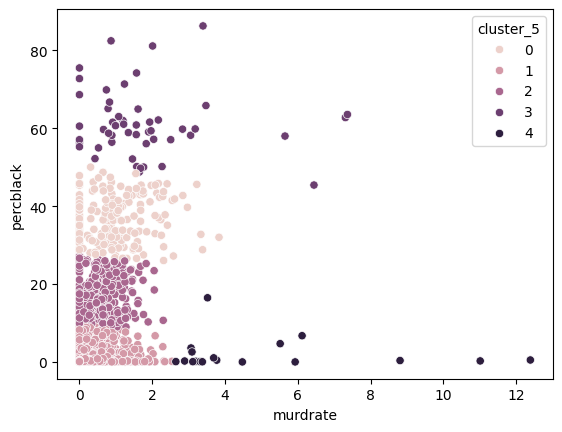

In [144]:
kmeans = KMeans(n_clusters = 5, random_state=0, n_init="auto").fit(X_norm)
X['cluster_5'] = kmeans.labels_
sns.scatterplot(x = 'murdrate', y = 'percblack', hue = 'cluster_5', data = X)

### Проведем кластеризацию, используя все переменные, доступные в данных

In [148]:
minmaxscaler =  MinMaxScaler().fit(data[num_vars + target_var])  # fit does nothing
X_norm = minmaxscaler.transform(data[num_vars + target_var])

Text(0.5, 1.0, 'Elbow curve')

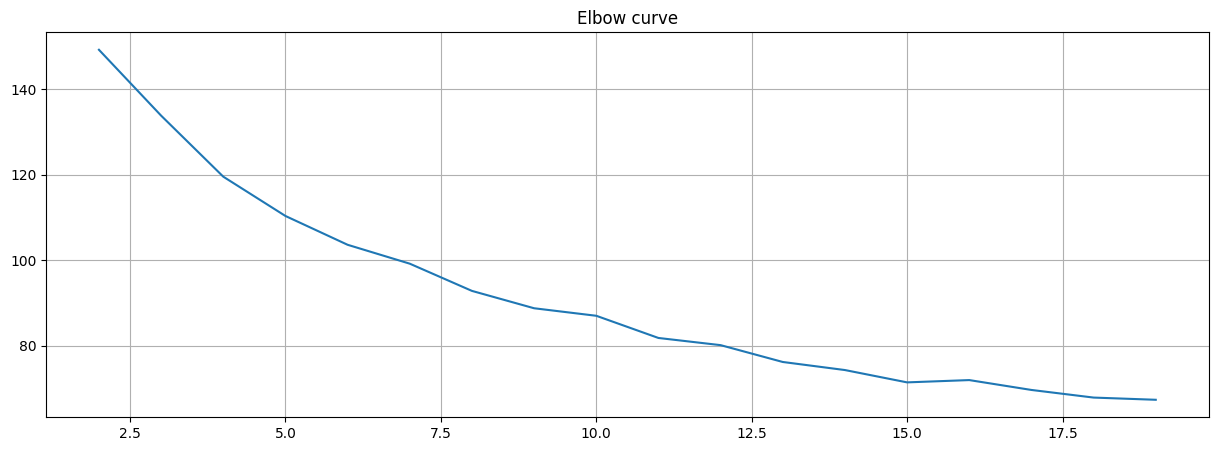

In [151]:
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_norm)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

Выбирая между интерпретируемостью и точностью разделения, примем 10 кластеров за оптимальное число

In [155]:
kmeans = KMeans(n_clusters = 10, random_state=0, n_init="auto").fit(X_norm)
data['cluster'] = kmeans.labels_

In [157]:
data.groupby('cluster')[num_vars+target_var].mean()

,arrestrate,density,perc1019,perc2029,percblack,percmale,rpcincmaint,rpcpersinc,rpcunemins,execrate,murdrate
cluster,,,,,,,,,,,
0,1.667284,981.051724,16.034964,13.487021,50.467404,47.770825,421.767500,11066.379500,50.204000,0.006046,1.463844
1,0.391963,32.798465,14.281874,14.691693,8.981301,54.756658,203.828886,10725.305215,47.026253,0.028202,0.352699
2,0.256881,177.496001,14.503803,12.273741,3.515998,49.167119,136.044263,13970.351220,39.923035,0.002468,0.242997
3,0.890546,315.767046,14.618594,12.944408,26.248852,48.298273,247.746293,12422.238923,38.536756,0.001447,0.793995
4,0.341983,209.783453,15.260277,10.698677,1.903437,49.950666,233.314098,12068.927333,156.184902,0.000510,0.380095
5,0.287048,250.437243,16.740551,20.087174,6.039205,49.765423,144.808112,12551.546860,34.106168,0.001154,0.248627
6,0.349071,2548.132091,12.331838,13.595496,8.693043,49.042309,156.175684,21848.268026,61.802053,0.000279,0.359735
7,0.219059,24.210229,16.070438,9.820634,1.565667,49.370673,193.832748,11433.221308,33.291675,0.000224,0.228462
8,4.748166,10.234462,16.332431,9.734558,5.062744,50.098237,293.976222,10509.159481,34.711926,0.000000,3.558255


<Axes: xlabel='murdrate', ylabel='percblack'>

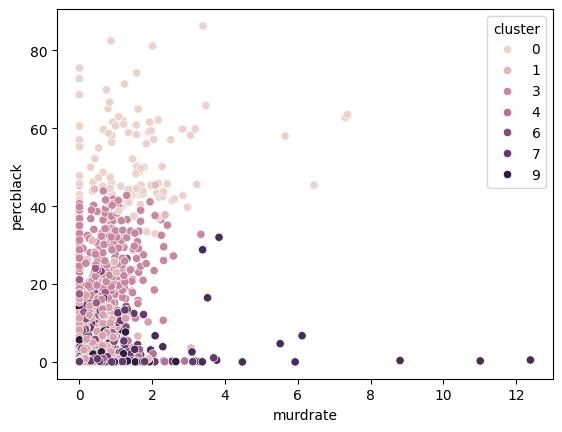

In [154]:
sns.scatterplot(x = 'murdrate', y = 'percblack', hue = 'cluster', data = data)

На базе сравнения средних величин по переменным можно каждому кластеру дать содержательную интерпретацию

Например, кластер 6 включает графства с высокой плотностью населения

Кластер 8 включает графства с высоким процентом арестов

Кластер 0 - это графства с самым высоким процентом черного населения 

И т.д.

В кластере 8 самый высокий процент убийств и при этом отсутствует смертная казнь. Значит ли это, что отсутствие смертной казни ведет к повышению преступности?